# Predicting Tensile time series value, based on LSTM

In [1]:
!nvidia-smi

Mon Mar  7 23:59:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    75W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install --upgrade pip -q
!pip install pytorch_lightning -q

In [3]:
import pandas as pd 
import numpy as np
import torch
import pytorch_lightning as pl
from pathlib import Path
from tqdm.notebook import tqdm
from torch import nn, optim

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.progress import TQDMProgressBar

In [4]:
in_colab=False

try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    in_colab=True
except: 
    pass

Mounted at /content/drive


### Notebook parameters

In [5]:
DATA_PATH = Path('/content/drive/MyDrive/krafthack/data' if in_colab else './data/')

TEST_SPLIT_SIZE = .20
SEED = 125501
N_EPOCHS=1 # max epochs if early stop doesn't stop the execution

FRAC=1 # train on fraction of train/test dfs for faster development, should be 1 in final solution

BOLT = 4

In [6]:
df = pd.read_parquet(DATA_PATH / 'input_dataset-2.parquet')

## Features generation

In [7]:
FEATURE_COLUMNS = df.columns.tolist()[:7]

NOT_USED_FEATURES = ['Unit_4_Reactive Power']

for f in NOT_USED_FEATURES:
  if f in FEATURE_COLUMNS:
    FEATURE_COLUMNS.remove(f)

LABEL_COLUMN = f'Bolt_{BOLT}_Tensile'

In [8]:
FEATURE_COLUMNS

['Unit_4_Power',
 'Turbine_Guide Vane Opening',
 'Turbine_Pressure Drafttube',
 'Turbine_Pressure Spiral Casing',
 'Turbine_Rotational Speed',
 'mode']

In [9]:
pl.seed_everything(seed=SEED)

Global seed set to 125501


125501

In [10]:
def add_elapsed(df):
    """elapsed time since last start"""
    df["_t"] = df.index

    shifted = df['mode'].shift(1).fillna(0)

    df["_change"] = (df['mode'] == 1) & (shifted == 0)
    
    # mimics start at t=0 --> wrong -> impute value instead
    df["_change"].iloc[0]=True
    df["elapsed"] = (df['_t']-df['_t'].where(df["_change"]).ffill()).dt.total_seconds()

    # impute values for first interval (as it starts at "operational" state)
    i_first_start = df.index.get_loc(df.index[df["mode"] == 1][0])
    df.iloc[:i_first_start]["elapsed"] += df["elapsed"].mean()

    del df['_t']
    del df['_change']


In [11]:
features_df = df[FEATURE_COLUMNS].copy()
features_df['label_shift'] = df[LABEL_COLUMN].shift(1)
# encode date, todo: year?
features_df['day'] = features_df.index.day
features_df['month'] = features_df.index.month
features_df['hour'] = features_df.index.month
features_df['minute'] = features_df.index.minute
features_df['second'] = features_df.index.second
features_df['label'] = df[LABEL_COLUMN]

features_df['label_change'] = features_df.apply(lambda row: 0 if np.isnan(row.label_shift) else row.label_shift - row.label, axis=1)

features_df.dropna(inplace=True)

del features_df['label_shift']

mode_le = LabelEncoder()

features_df['mode'] = mode_le.fit_transform(features_df['mode'].values)

In [12]:
train_df, test_df = train_test_split(features_df, test_size=TEST_SPLIT_SIZE, shuffle=False)

In [13]:
len(test_df)

349991

In [14]:
add_elapsed(train_df)
add_elapsed(test_df)

FEATURE_COLUMNS += ["elapsed", "day", "month", "hour", "minute", "second", "label_change"]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [15]:
# get a fraction of dfs
train_df = train_df.head(int(train_df.shape[0] * FRAC))
test_df = test_df.head(int(test_df.shape[0] * FRAC))

In [16]:
scaler = MinMaxScaler(feature_range=(-1, 1))

scaler.fit(train_df) # scale fit only on train, to remove data

train_df = pd.DataFrame(
    scaler.transform(train_df), index=train_df.index, columns=train_df.columns
)

test_df = pd.DataFrame(
    scaler.transform(test_df), index=test_df.index, columns=test_df.columns
)

In [17]:
print(train_df.shape)
print(test_df.shape)

(1399963, 14)
(349991, 14)


In [18]:
train_df.head(2)

,Unit_4_Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,mode,day,month,hour,minute,second,label,label_change,elapsed
timepoints,,,,,,,,,,,,,,
1970-12-19 09:51:45,0.621419,0.708112,-0.419069,0.711607,0.99249,-1.0,0.2,1.0,1.0,0.728814,0.525424,0.840848,-0.752853,-0.547797
1970-12-19 09:51:46,0.620801,0.708055,-0.418549,0.712209,0.99249,-1.0,0.2,1.0,1.0,0.728814,0.559322,0.841146,-0.752904,-0.547793


In [19]:
def create_sequences(input_data: pd.DataFrame, feature_columns, target_column, sequence_length=30):
    sequences = []
    data_size = len(input_data)

    sequence_ = input_data[feature_columns][:sequence_length].to_numpy().tolist()
    all_labels = input_data[target_column].to_list()

    sequences.append((sequence_, all_labels[sequence_length + 1]))
    

    for i in tqdm(range(1, data_size - sequence_length)):
        row_dict = input_data.iloc[i].to_dict()
        feats = [row_dict[x] for x in feature_columns]

        sequence_.pop(0)
        sequence_.append(feats)

        label_position = i + sequence_length
        label = all_labels[label_position]
        sequences.append((sequence_.copy(), label))

    return sequences

In [20]:
train_sequences = create_sequences(train_df, FEATURE_COLUMNS, 'label')

  0%|          | 0/1399932 [00:00<?, ?it/s]

In [21]:
test_sequences = create_sequences(test_df, FEATURE_COLUMNS, 'label')

  0%|          | 0/349960 [00:00<?, ?it/s]

## Dataset wrappers

In [22]:
class KrafthackDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]

        return dict(
            sequence=torch.Tensor(sequence), 
            label=torch.tensor(label).float()
        )


In [23]:
class KrafthackDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size=256):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self):
        self.train_dataset = KrafthackDataset(self.train_sequences)
        self.test_dataset = KrafthackDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=2
        )

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1, shuffle=False, num_workers=1)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1, shuffle=False, num_workers=1)


In [24]:
data_module = KrafthackDataModule(
    train_sequences=train_sequences, test_sequences=test_sequences, batch_size=4096
)

data_module.setup()

In [25]:
class TensilePredictionModel(nn.Module):
    def __init__(self, n_features, n_hidden=16, n_layers=3):
        super().__init__()

        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers,
            dropout=0.35,
        )

        self.regressor = nn.Linear(n_hidden, 1)

    def forward(self, x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)

        logits = hidden[-1]

        return self.regressor(logits)


In [26]:
class TensilePredictor(pl.LightningModule):
    def __init__(self, n_features: int):
        super().__init__()

        self.model = TensilePredictionModel(n_features)

        self.criterion = nn.MSELoss()

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0

        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))

        return loss, output

    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, _ = self(sequences, labels)
        self.log("training_loss", loss, prog_bar=True, logger=True)

        return loss

    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, _ = self(sequences, labels)
        self.log("validation_loss", loss, prog_bar=True, logger=True)

        return loss

    def test_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, _ = self(sequences, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)

        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.001)


In [27]:
# remove one feature, which is the label
model = TensilePredictor(n_features = train_df.shape[1] - 1)

In [28]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename=f"best_checkpoint_bolt_{BOLT}",
    save_top_k=1,
    verbose=True,
    monitor="validation_loss",
    mode="min",
)

logger = TensorBoardLogger("lightning_logs", name="tensile-pred")

progress_callback = TQDMProgressBar(refresh_rate=10)

early_stopping_callback = EarlyStopping(
    monitor="validation_loss",
    patience=2
)

trainer = pl.Trainer(
    logger=logger,
    enable_checkpointing=True,
    callbacks=[early_stopping_callback, progress_callback, checkpoint_callback],
    max_epochs=N_EPOCHS,
    precision=16,
    accumulate_grad_batches=16,
    gpus = 1 if in_colab else 0
)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [29]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs

In [30]:
trainer.fit(model, data_module)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Missing logger folder: lightning_logs/tensile-pred

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | TensilePredictionModel | 6.4 K 
1 | criterion | MSELoss                | 0     
-----------------------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.013     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 125501


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 21: validation_loss reached 0.37422 (best 0.37422), saving model to "/content/checkpoints/best_checkpoint_bolt_4.ckpt" as top 1


## model evaluation

In [31]:
checkpoint_path = trainer.checkpoint_callback.best_model_path

print('Loading: ', checkpoint_path)

trained_model = TensilePredictor.load_from_checkpoint(checkpoint_path, 
                                                      n_features=train_df.shape[1] - 1)

Loading:  /content/checkpoints/best_checkpoint_bolt_4.ckpt


In [32]:
trained_model.freeze()

In [34]:
td = KrafthackDataset(test_sequences)

predictions = []
labels = []

for item in tqdm(td):
    sequence = item['sequence']
    label = item['label']

    _, output = trained_model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())

  0%|          | 0/349961 [00:00<?, ?it/s]

In [35]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[-1], scaler.scale_[-1]

def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

In [36]:
predictions_descaled = descale(descaler, predictions)
labels_descaled = descale(descaler, labels)

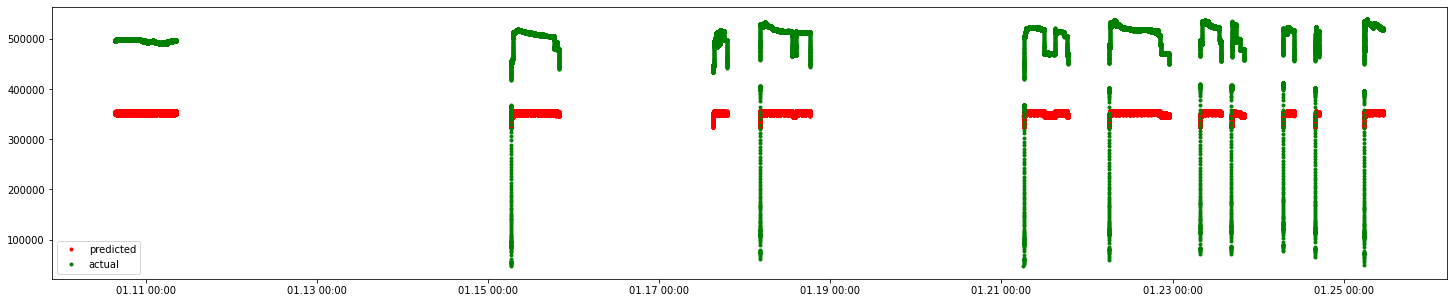

In [39]:
plt.figure(figsize=(25,5))
test_sequences_data = test_df[30:]
dates = matplotlib.dates.date2num(test_sequences_data.index.tolist())
plt.plot_date(dates, predictions_descaled, '.', label='predicted', color='r')
plt.plot_date(dates, labels_descaled, '.', label='actual', color='g')
plt.legend()
# plt.xticks(rotation=15);
dtFmt = mdates.DateFormatter('%m.%d %H:%M') # define the formatting
plt.gca().xaxis.set_major_formatter(dtFmt) # apply the format to the desired axis
plt.show()